In [9]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    #sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count, Q
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import igraph
#import mpld3

from adjustText import adjust_text

In [3]:
p = sm.Project.objects.get(pk=196)

In [4]:
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [12]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project_list=p)

In [13]:
ttweets = set(tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
).values_list('id',flat=True))

In [14]:
print(len(ttweets))

233059


---

## Language from BaseModel

In [15]:
random.seed(123)
test_texts = tm.Status.objects.filter(
    id__in=random.sample(ttweets, 1000)
).values_list('text', 'lang')

In [16]:
df_test = pd.DataFrame(list(test_texts), columns=['text', 'lang'])

In [18]:
is_de = df_test["lang"]=="de"
df_de = df_test[is_de]

In [19]:
df_de.head()

,text,lang
0,Atom- und Kohleausstieg gleichzeitig geht nich...,de
1,@ntvde Ich hätte zuerst Kohleausstieg bzw. Aus...,de
2,So eindeutig/konsequent Schwarz/Gelb Energiewe...,de
3,"Schade. Der ""Kohleausstieg bis 2030"" hat nur f...",de
4,SRU Vorsitzender empfiehlt Kohleausstieg\nZEIT...,de


In [10]:
#df_test.to_csv("df_test.csv")

In [13]:
#df_de.to_csv('df_de.csv')

---

## Filter for relevant keywords

filter tweets in 'Kohle' set using relevant hashtags, then add tweets from other TS objects to joint dataset?  

In [7]:
# Q lookup must precede any keyword argument
ktf = tm.Status.objects.filter(
    Q(text__icontains = '#hambacherforst') |
    Q(text__icontains = '#fridaysforfuture') |
    Q(text__icontains = '#endegelaende') |
    Q(text__icontains = '#hambacherwald') |
    Q(text__icontains = '#lausitz') |
    Q(text__icontains = '#klimaschutz') |
    Q(text__icontains = '#klimawandel') |
    Q(text__icontains = '#klimakrise') |
    Q(text__icontains = '#klima')
)
#.filter(text__icontains="Kohle")

ktf.count()

1132554

In [8]:
ktff = ktf.filter(
    text__icontains="Kohle"
).filter(
    created_at__lte=end_date
)
ktff.count()

77733

In [20]:
query2 = tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
)

### combining tweets

In [21]:
qcomb = ktff | query2

In [22]:
qcomb.count()

350804

In [25]:
qcomb_ids = set(qcomb.values_list('id',flat=True))

---

## Sentiment Analysis

In [30]:
import spacy
from spacy_sentiws import spaCySentiWS

nlp = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path='../SentiWS')
nlp.add_pipe(sentiws)

In [276]:
def get_senti_score(tweet):
    """gets the score of a tweet from SentiWS"""
    scores = []
    for token in tweet:
        score = token._.sentiws
        if score is not None:
            scores.append(score)
    
    if sum(scores) != 0:
        return sum(scores)/len(scores)
    else:
        return 0

### testing on small set

In [47]:
df_de.iloc[2]['text']

'So eindeutig/konsequent Schwarz/Gelb Energiewende blockiert, so unentschlossen ist SPD in Sachen Kohleausstieg und Offshore-Wahnsinn. Schade'

In [51]:
len(df_de.iloc[2]['text'].split())

15

In [277]:
doc = nlp(df_de.iloc[2]['text'])
for token in doc: 
    print('{}, {}, {}'.format(token.text, token._.sentiws, token.pos_))

So, None, ADV
eindeutig/konsequent, None, VERB
Schwarz/Gelb, None, PROPN
Energiewende, None, NOUN
blockiert, -0.3459, VERB
,, None, PUNCT
so, None, ADV
unentschlossen, None, ADJ
ist, None, AUX
SPD, None, PROPN
in, None, ADP
Sachen, None, NOUN
Kohleausstieg, None, NOUN
und, None, CONJ
Offshore-Wahnsinn, None, NOUN
., None, PUNCT
Schade, -0.0048, ADJ


In [278]:
get_senti_score(doc)

-0.17535

In [279]:
tweet_scores = []
for i in df_de.index:
    entry = df_de.loc[i]
    doc = nlp(entry['text'])
    tweet_score = get_senti_score(doc)
    tweet_scores.append(tweet_score)

In [280]:
df_de['score'] = tweet_scores

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
#df_de.to_csv("df_de_scores2.csv")

In [281]:
most_neg = df_de.sort_values(by=['score'])[0:5]
for i in most_neg.index:
    print(most_neg.loc[i]['text'])

16:36 Eine Person wird aus der Traverse geholt. Geräumte Person vom Tripod in schlechter körperlicher Verfassung, Schuld ist gerissener Geduldsfaden der Polizei – Räumungen werden gewaltätiger.
#hambibleibt #HambacherForst
Bin zum ersten mal im Wald. Ist voll der taktische Nachteil. Hier kann man nichtmal Graffities sprühen #hambibleibt #HambacherForst
Ein schlechter Tag für @RWE_AG und ein WUNDERSCHÖN FLUFFIG-FLAUSCHIG-SONNIGER Tag für den #Hambi. #hambibleibt #HambacherForst https://t.co/ksSlAPe11z
Eine Aktivistin aus dem Hambacher Forst wurde nach 4 Monaten U-Haft nun zu 9 Monaten ohne Bewährung verurteilt. Begründung: Sie soll trommelnd (!) eine Gruppe "unterstüzt" haben, aus der Böller auf Cops geworfen worden sein sollen.

#hambibleibt #hambacherforst #nojusticenopeace https://t.co/duzAfg84TN
"Streit um Hambacher Forst: Aktivisten dringen in #Staatskanzlei ein https://t.co/c6KFfeG7jH … #HambacherForst" -@tagesschau 
#onestruggleonefight #hambibleibt #nrw #deutschland 
#HumanRight

In [282]:
most_pos = df_de.sort_values(by=['score'], ascending=False)[0:5]
for i in most_pos.index:
    print(most_pos.loc[i]['text'])

Spannender Augenzeugenbericht zum Tagebau #hambach dem #Hambacherforst und dessen entwicklung #Hambibleibt https://t.co/jSylMYyFvL
Der Link wurd mir eben zu gesendet , sehr interessantes und gelungenes Video!

Hambacher Forst Projekt https://t.co/YbzYNK6F6j via @YouTube
#HambiGehtWeiter #HambiBleibt #Hambimahni #Manheimlebt #fossilfree @HambiBleibt @HambiMahnwache @manheimlebt
Zum #TagdesBaumes mit freundlichen Grüssen von den #PIRATEN
#HambiBleibt #HambacherForst https://t.co/aA97pJXNu9
Ein hervorragender Kommentar zum Vorgehen der Landesregierung und @RWE_AG #HambacherForst #HambiBleibt @HambiBleibt 
 https://t.co/Ul2vml9cnF
Diese Feuerstelle könnte ich mir auch prima im Hambi vorstellen 👍🐿️🌳

#hambibleibt 
#HambacherForst https://t.co/igV7Y7vwqN


---

### Actual

In [68]:
texts = tm.Status.objects.filter(
    id__in=qcomb_ids
).values_list('id','created_at','text', 'lang')

In [69]:
df_texts = pd.DataFrame(list(texts), columns=['id','created_at','text', 'lang'])

In [70]:
is_de = df_texts["lang"]=="de"
texts_de = df_texts[is_de]

In [283]:
texts_scores = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    doc = nlp(entry['text'])
    tweet_score = get_senti_score(doc)
    texts_scores.append(tweet_score)

In [284]:
texts_de['score'] = texts_scores

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [285]:
texts_de.to_csv('texts_de_20200221.csv')

---

### Results

In [4]:
#texts_de = pd.read_csv('texts_de.csv', index_col=[0])

In [74]:
# Style
sns.set_style('whitegrid')

In [286]:
# convert to datetime object
texts_de['created_at'] =  pd.to_datetime(texts_de['created_at'])

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [287]:
texts_de.head()

,id,created_at,text,lang,score,date_only
1,5944270614,2009-11-22 11:55:21+00:00,"Die USA bremsen #Klimaabkommen, weil sie noch ...",de,0.004000,2009-11-22
2,5978704331,2009-11-23 15:17:24+00:00,#Schottland: #Waldbesetzung gegen #Kohle-#Tage...,de,-0.340800,2009-11-23
3,6089959841,2009-11-26 19:18:40+00:00,#Klimaschutz: Eine Maßnahme hilft wirklich: Ko...,de,0.086533,2009-11-26
4,6230764335,2009-12-01 09:41:27+00:00,ak2 diskutiert Mindestwirkungsgrad bei Kohle- ...,de,0.000000,2009-12-01
5,6265364638,2009-12-02 10:05:53+00:00,#Klimawandel: im Moment haben offenbar die Pro...,de,0.000000,2009-12-02


In [289]:
len(texts_de)

240927

In [288]:
average_score = sum(texts_de['score'])/len(texts_de['score'])
average_score

-0.018609002795491433

In [290]:
texts_de_daily_count = texts_de.groupby(pd.Grouper(key='created_at',freq='D'))['id'].count()

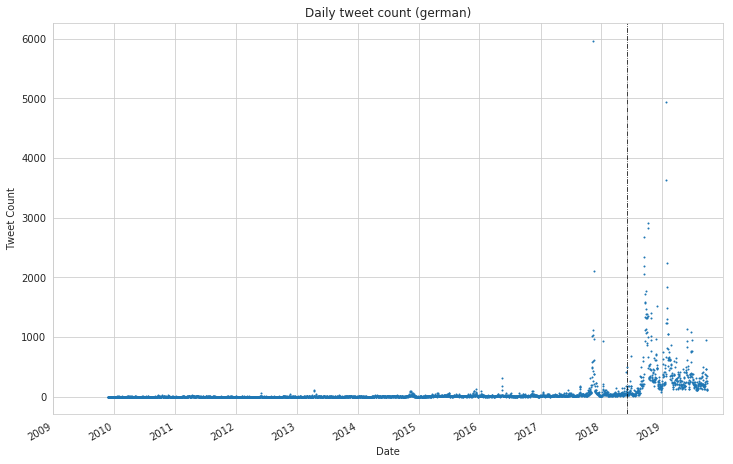

In [272]:
# tweet freq over time
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count, marker='.', s=6, edgecolor=None)
ax.set(xlim=(datetime.datetime.strptime('2009-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')),
       #ylim=(0,1000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count (german)")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

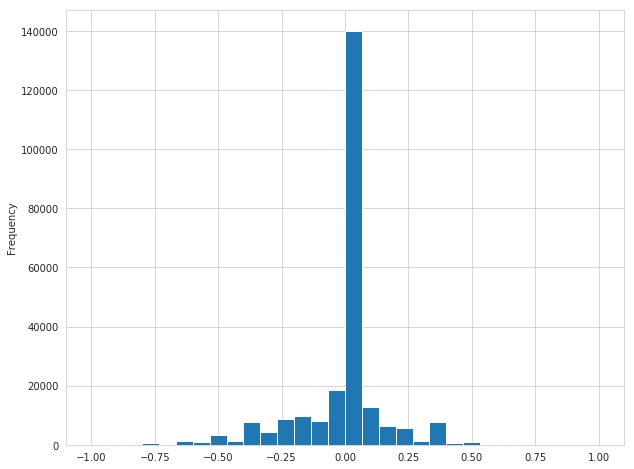

In [291]:
fig, ax = plt.subplots(figsize=(10,8))

texts_de['score'].plot.hist(bins=30)

plt.show()

In [292]:
most_neg = texts_de.sort_values(by=['score'])[0:10]
for i in most_neg.index:
    print(most_neg.loc[i]['text'])

@SoliDavidwache @PiratNrw @polizeyer Ihr Kollege verlangt nach einem gesellschaftlichen Bezug zu #Chemnitz und sie verlangen auch explizit nach dem Vergleich. Die Menschen von #hambibleibt stellen aber höchstens eine Gefahr für die PolizistInnen im Wald und RWE dar.
#RWE dank Charttechnik an DAX-Spitze: Konzernchef Schmitz prangert „Kohleausstieg mit Brechstange“ an -&gt; Gefahr für https://t.co/mkWugFncay https://t.co/tzRrQGDvAg
#HambacherForst #Hambibleibt https://t.co/uUBOs2lkrU Archiv für alternatives Schrifttum in Duisburg - "Gegenüberlieferung" in Gefahr - Deutschlandfunk
Milliardenkosten durch #Kohlestrom - Atlas analysiert Gefahren #BUND #HeinrichBöllStiftung #Kohleausstieg http://t.co/9WLZEEh9h1
RWE sieht bei Kohleausstieg Eigentumsrechte in Gefahr / 27.04.2018 https://t.co/YhvGiobGuV https://t.co/y5QaYPvCRf
#HambacherForst #Hambibleibt https://t.co/0F524tsJYl Hambacher Forst in Gefahr: RWE geht an die Wurzeln - https://t.co/93l2MWmqd7
@Umweltrat @RNE_DE @WBGU_Council @natursc

In [293]:
most_pos = texts_de.sort_values(by=['score'], ascending=False)[0:10]
for i in most_pos.index:
    print(most_pos.loc[i]['text'])

Ein sehr gelungener Thread über den #Hambi, die Besetzung, Ideale etc #hambibleibt #HambacherForst https://t.co/mgqXolG1Sv
#Karlsruhe tanzt für den #Kohleausstieg! Was für ein Gelungener Tag. #EndeGelaende #hambibleibt! @Ende__Gelaende #KoKolores https://t.co/p42aT70Y4S
Bus bringt Aktivisten @Ende__Gelaende nach gelungener #Kohle-Blockade jetzt nach Aussage @Polizei_NRW_AC zum #klimacamp #EndCoal
RT @p4xy0: War heute eine gelungene Aktion der Klima-Allianz! #RausAusDerKohle 
#klima #umwelt #bundestag #naturschutz #kohle http://t.co/i…
Nach einem gelungen Aktionstraining, gibt es jetzt erstmal KÜFA und um 16.30 eine #HambiBleibt Demo in #Aachen. #AktionUnterholz #stopcoal #EndeGelände https://t.co/FmvnFlYJhc
Vielen Dank an die Initiatoren und dessen Veranstaltungsteam zur gelungenen Demonstration: Tempo machen beim Kohleausstieg! https://t.co/36kT1xSajy
RT @p4xy0: War heute eine gelungene Aktion der Klima-Allianz! #RausAusDerKohle 
#klima #umwelt #bundestag #naturschutz #kohle http://t.

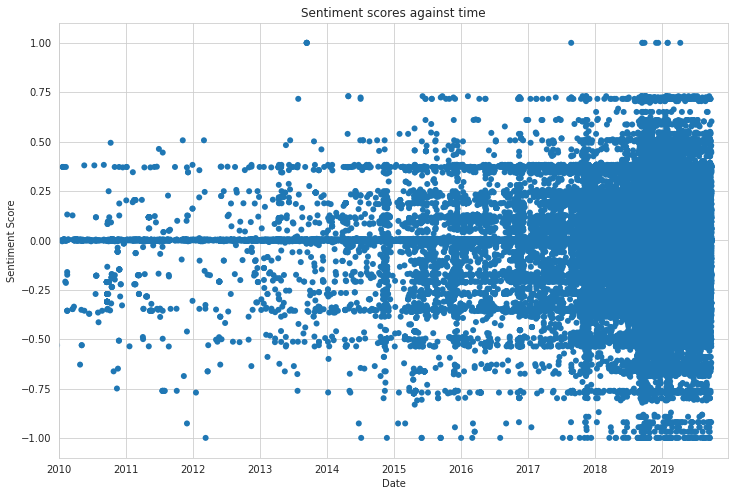

In [294]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de['created_at'], texts_de['score'], edgecolor='', ax = ax)
ax.set(xlim=(datetime.datetime.strptime('2010-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')), xlabel="Date",ylabel="Sentiment Score", title="Sentiment scores against time")
plt.show()

In [295]:
texts_de_daily = texts_de.groupby(pd.Grouper(key='created_at',freq='D'))['score'].mean()

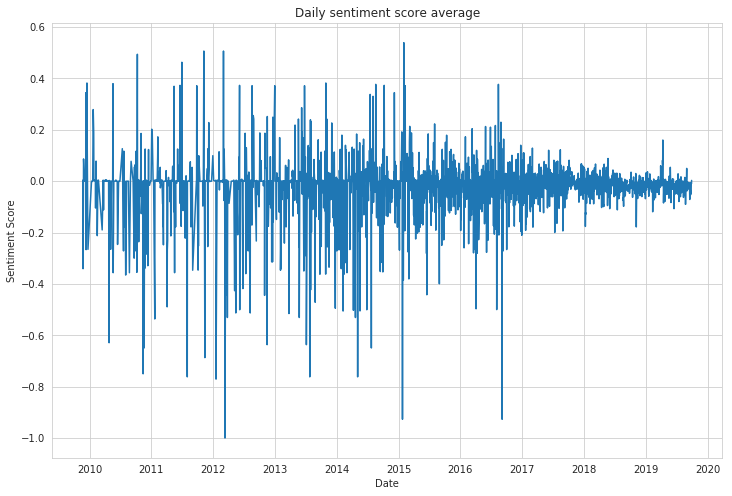

In [296]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.set(xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
fig.savefig('plots/dailyavgsenti.png', dpi=300)

In [297]:
texts_de_monthly = texts_de.groupby(pd.Grouper(key='created_at',freq='M'))['score'].mean()

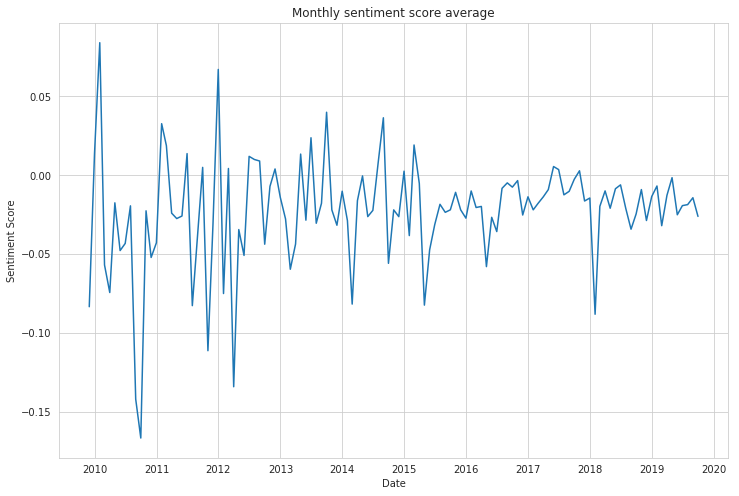

In [298]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_monthly.index, texts_de_monthly, ax = ax)
ax.set(xlabel="Date",ylabel="Sentiment Score", title="Monthly sentiment score average")
plt.show()
fig.savefig('plots/monthlyavgsenti.png', dpi=300)

In [299]:
texts_de_yearly = texts_de.groupby(pd.Grouper(key='created_at',freq='Y'))['score'].mean()

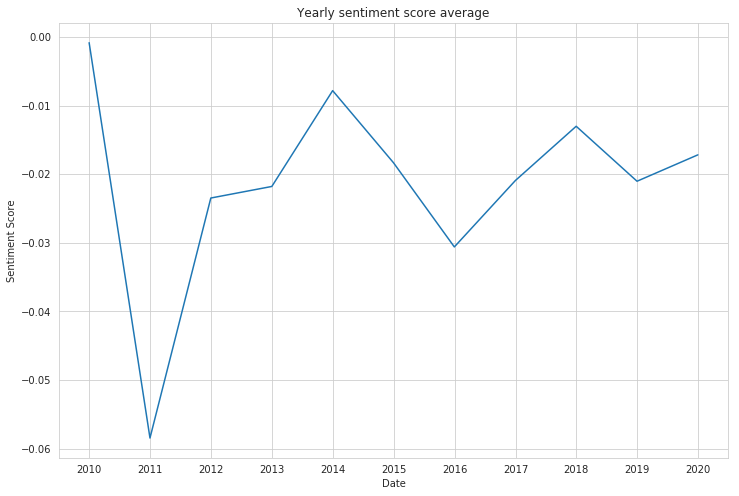

In [300]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_yearly.index, texts_de_yearly, ax = ax)
ax.set(xlabel="Date",ylabel="Sentiment Score", title="Yearly sentiment score average")
plt.show()
fig.savefig('plots/yearlyavgsenti.png', dpi=300)

### A Closer Look

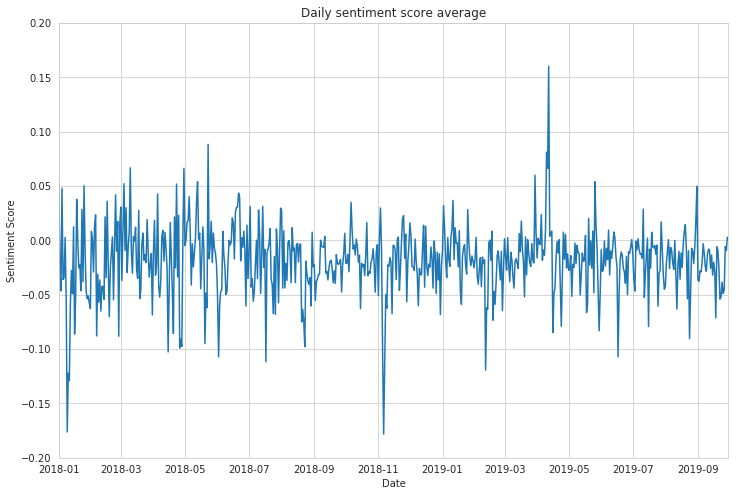

In [304]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.set(xlim=(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-09-30', '%Y-%m-%d')),
       ylim=(-0.2,0.2),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
#fig.savefig('plots/dailyavgsenti.png', dpi=300)

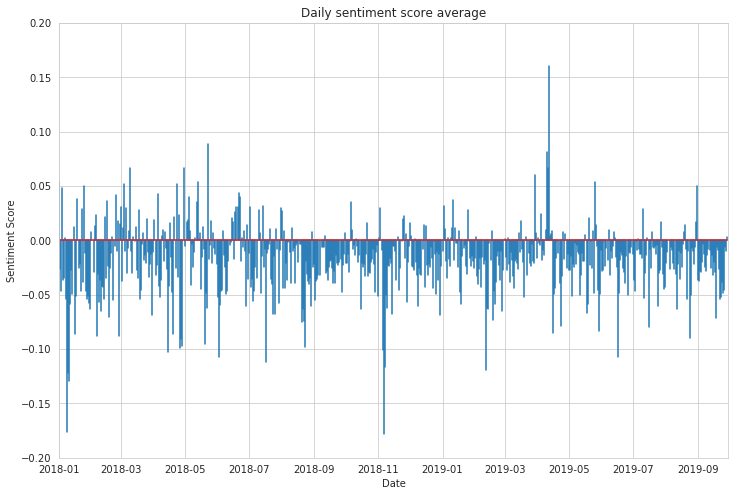

In [305]:
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-09-30', '%Y-%m-%d')),
       ylim=(-0.2,0.2),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
#fig.savefig('plots/dailyavgsenti.png', dpi=300)

In [130]:
start_date = datetime.datetime.strptime('2018-01-01-+0000', '%Y-%m-%d-%z')
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [306]:
date_range = (texts_de_daily.index >= start_date) & (texts_de_daily.index <= end_date)

In [307]:
texts_de_daily[date_range].sort_values(ascending=False)[:5]

created_at
2019-04-12 00:00:00+00:00    0.160162
2018-05-23 00:00:00+00:00    0.088231
2019-04-10 00:00:00+00:00    0.081059
2018-03-10 00:00:00+00:00    0.066678
2018-04-30 00:00:00+00:00    0.066263
Name: score, dtype: float64

In [308]:
texts_de_daily[date_range].sort_values()[:5]

created_at
2018-11-06 00:00:00+00:00   -0.178181
2018-01-09 00:00:00+00:00   -0.176219
2018-01-11 00:00:00+00:00   -0.128984
2018-01-10 00:00:00+00:00   -0.122176
2019-02-11 00:00:00+00:00   -0.119207
Name: score, dtype: float64

In [311]:
# return new column with date 
date_only = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    entry_date = entry['created_at'].date()
    date_only.append(entry_date)

In [312]:
texts_de['date_only'] = date_only
texts_de.head()

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,created_at,text,lang,score,date_only
1,5944270614,2009-11-22 11:55:21+00:00,"Die USA bremsen #Klimaabkommen, weil sie noch ...",de,0.004000,2009-11-22
2,5978704331,2009-11-23 15:17:24+00:00,#Schottland: #Waldbesetzung gegen #Kohle-#Tage...,de,-0.340800,2009-11-23
3,6089959841,2009-11-26 19:18:40+00:00,#Klimaschutz: Eine Maßnahme hilft wirklich: Ko...,de,0.086533,2009-11-26
4,6230764335,2009-12-01 09:41:27+00:00,ak2 diskutiert Mindestwirkungsgrad bei Kohle- ...,de,0.000000,2009-12-01
5,6265364638,2009-12-02 10:05:53+00:00,#Klimawandel: im Moment haben offenbar die Pro...,de,0.000000,2009-12-02


In [313]:
positive_day = texts_de['date_only'] == datetime.date(2019,4,12)
positive_day_tweets = texts_de[positive_day]

In [314]:
positive_day_tweets.sort_values(by='score', ascending=False)[:20]

,id,created_at,text,lang,score,date_only
223251,1116672151451504641,2019-04-12 11:59:22+00:00,Gelungene Premiere in Fürth - Danke @FridaysFo...,de,1.0000,2019-04-12
223299,1116706328347598849,2019-04-12 14:15:10+00:00,RT @julia_verlinden: Großartig!👍\n#DieAnstalt ...,de,0.4606,2019-04-12
223226,1116659215735586816,2019-04-12 11:07:58+00:00,Berlin tanzt fürs Klima - großartig! Danke @FF...,de,0.4606,2019-04-12
223246,1116668024415838208,2019-04-12 11:42:58+00:00,Großartig - Danke @FfFbbg_ \n#FridaysForFurtur...,de,0.4606,2019-04-12
223395,1116843257332473857,2019-04-12 23:19:17+00:00,Sehr gut!!! #FridaysForFuture #Klimawandel #...,de,0.3716,2019-04-12
223275,1116688930756341760,2019-04-12 13:06:02+00:00,Heute wieder @F4F_Potsdam-Demo in #Potsdam. Es...,de,0.3716,2019-04-12
223107,1116590583479275522,2019-04-12 06:35:15+00:00,Guten Morgen! Heute bei @dpa_Ost: BER und die ...,de,0.3716,2019-04-12
223337,1116746240664973314,2019-04-12 16:53:46+00:00,@OldTomBom @DaniBrodesser @JoanHoban Eine brei...,de,0.3716,2019-04-12
223170,1116629081150361600,2019-04-12 09:08:13+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.3583,2019-04-12
223174,1116630177075744768,2019-04-12 09:12:34+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.3583,2019-04-12


In [315]:
most_pos_day = positive_day_tweets.sort_values(by='score', ascending=False)
for i in most_pos_day.index[:10]:
    print(most_pos_day.loc[i]['text'])

Gelungene Premiere in Fürth - Danke @FridaysForFut12 
#FridaysForFurture #ParentsForFuture #ScientistsForFuture #alledörferbleiben #hambibleibt https://t.co/PcC7htJMSF
RT @julia_verlinden: Großartig!👍
#DieAnstalt im @ZDF mit "#Scheuermann" auf der Titanic, die ca 6 Grad Celsius vom Kurs nach #Paris abgekom…
Berlin tanzt fürs Klima - großartig! Danke @FFF_Berlin #FridaysForFurture #ParentsForFuture #scientists4future #alledörferbleiben #hambibleibt https://t.co/JRyLLdF6SV
Großartig - Danke @FfFbbg_ 
#FridaysForFurture #ParentsForFuture #scientists4future #alledörferbleiben #hambibleibt https://t.co/1mYUu7RoYI
Sehr gut!!! #FridaysForFuture  #Klimawandel  #CambioClimático 
Dieses Jahr 2019 in #Chile haben #COP25 #COP25CL 
Hier sagen wir nein zu #Kohle #Carbón #BergbauKohle in
#IslaRiesco #Patagonien https://t.co/mIhKMTlUYV
Heute wieder @F4F_Potsdam-Demo in #Potsdam. Es wird wieder für einen besseren Klimaschutz und einen früheren Kohleausstieg demonstriert https://t.co/OaBYIrfrki https://

#### @Luisamneubauer
> Was die Regierung damit sagen möchte: Da hat die Kohlekommission ein Datum auf den Tisch gelegt, was uns so gut in den Kram passt - wäre ja schön blöd nur wegen so ein paar Halbstarken auf einmal echten Klimaschutz durchzusetzen, der wohlmöglich noch dem Parisabkommen entspricht.

https://twitter.com/luisamneubauer/status/1116443797448208402

In [316]:
negative_day = texts_de['date_only'] == datetime.date(2018,11,6)
negative_day_tweets = texts_de[negative_day]

In [317]:
negative_day_tweets.sort_values(by='score')[:20]

,id,created_at,text,lang,score,date_only
141511,1059836097017069568,2018-11-06 15:53:10+00:00,"Darf ich ""Lügenpresse"" sagen, ja ich darf das ...",de,-0.7706,2018-11-06
141678,1059951748180312065,2018-11-06 23:32:44+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
141372,1059775460605919233,2018-11-06 11:52:14+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
141373,1059775566927282177,2018-11-06 11:52:39+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
141385,1059780787996971009,2018-11-06 12:13:24+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
141654,1059927514481614848,2018-11-06 21:56:26+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
141387,1059781311601278976,2018-11-06 12:15:29+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
141389,1059784115610939392,2018-11-06 12:26:37+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
141652,1059926166012858370,2018-11-06 21:51:05+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
141404,1059787821920206855,2018-11-06 12:41:21+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06


In [318]:
most_neg_day = negative_day_tweets.sort_values(by='score')
for i in most_neg_day.index[:10]:
    print(most_neg_day.loc[i]['text'])

Darf ich "Lügenpresse" sagen, ja ich darf das und warum? Weil der @WDR schlecht oder gar nicht recherchiert hat. Vielleicht sogar direkt auf dem Schoß von HReul gesessen hat 👈
#HambiBleibt 
#Manheimlebt
#endegelaende 
#EndCoal
#presse
@WDR_Presse 
@WDRinvestigativ 
@WDR_live https://t.co/eOTkAY0wXZ
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…


#### @ARTE:Re:
> Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz immer emotionaler wird. ➡️ http://bit.ly/2AAXTvX #hambi #HambiGehtWeiter 

https://twitter.com/ARTEre/status/1059740775188234240

---

## Looking at specific events

### Launch of coal commission 2018-06-06

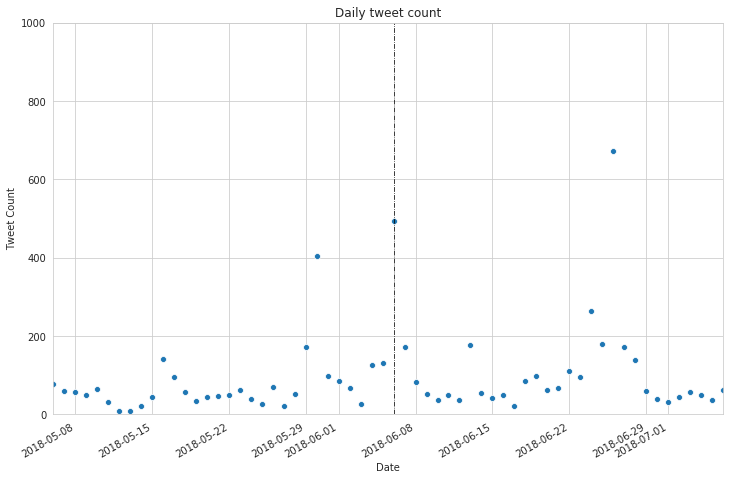

In [319]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-05-06', '%Y-%m-%d'), datetime.datetime.strptime('2018-07-06', '%Y-%m-%d')),
       ylim=(0,1000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

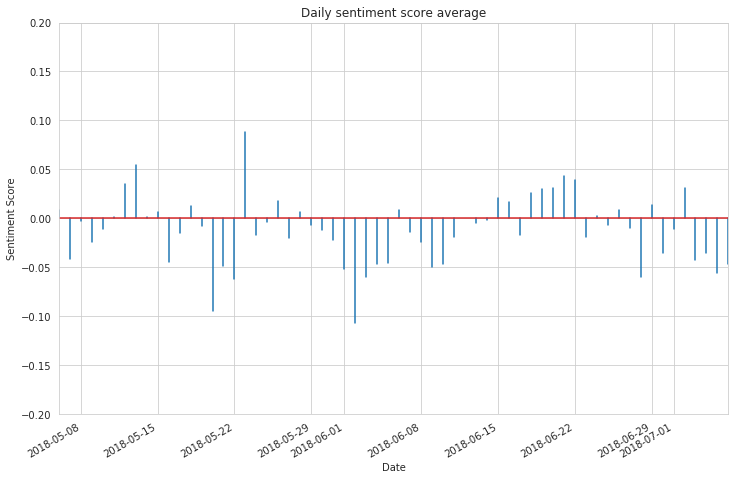

In [321]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-05-06', '%Y-%m-%d'), datetime.datetime.strptime('2018-07-06', '%Y-%m-%d')),
       ylim=(-0.2,0.2),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
#ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

In [322]:
# tweets 
event1 = texts_de['date_only'] == datetime.date(2018,6,6)
event1_tweets = texts_de[event1]

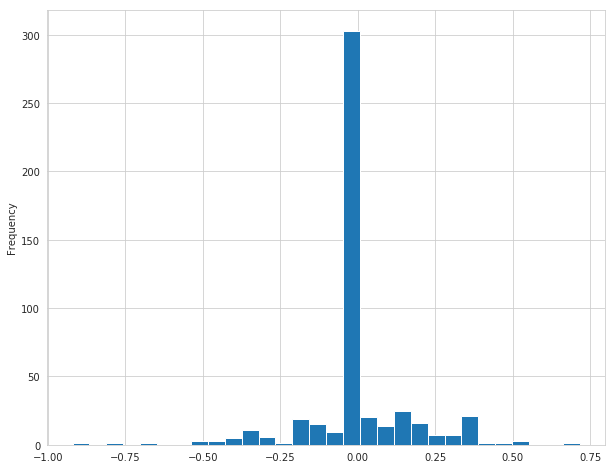

In [323]:
# spread of scores in the day
fig, ax = plt.subplots(figsize=(10,8))

event1_tweets['score'].plot.hist(bins=30)

plt.show()

In [324]:
event1_pos = event1_tweets.sort_values(by='score', ascending=False)
for i in event1_pos.index[:10]:
    print(event1_pos.loc[i]['text'])

Heute setzt BuReg #Kohlekommission ein &amp; wir @GrueneBundestag sind beim #Klimaschutz schon wieder Schritt weiter: spannendes Fachgespräch "Raus aus dem #Erdgas" mit
Dr. Bofinger v @fraunhofer_iee, @kirstenwestpha1 v @SWPBerlin, Regine Richter v @urgewald &amp; Ralph Bahke v FNB-Gas
Piratenpartei RT piratenparteibb: Ganz tolle Besetzung bei der Kohlekommission. Das wird wohl darauf hinaus laufen, dass noch der letzte Euro aus den Tagebauen gebuddelt wird und die Allgemeinheit dann auf den Renaturierungskosten mit einer zusammen brec… https://t.co/f2AFPL001K
Kohlekommission sollte mit Ruhe und Sorgfalt agieren https://t.co/3369hC4Bt3
📋 Kohlekommission sollte mit Ruhe und Sorgfalt agieren https://t.co/cgt6iejaFq ❚DIHK
@zukunft_erdgas Kohle ist ein Geschenk von Mutter Natur an den Menschen, um genutzt zu werden. Wir brauchen mehr Kohleabbau statt Kohleausstieg. #Kohlekommission https://t.co/ei0pjaWeAe
Heute wird die #Kohlekomission vom Bundeskabinett berufen. Mut zur Lücke braucht sie 

In [325]:
event1_neg = event1_tweets.sort_values(by='score')
for i in event1_neg.index[:10]:
    print(event1_neg.loc[i]['text'])

Wie Kohleausstieg @DFoest ? Atomkraft ist fast weg. Was sollen wir nachts bei schwachem Wind tun? Oder von Oktober bis Februar 16-10 Uhr? https://t.co/8rPQRD3VTD
Heute Start der #Kohlekommission. Vergoldung längst geplanter Abschaltungen!! Betroffene haben kein Gewicht in WBS, müssen schlechte Entscheidungen mittragen. Was sind Roten Linien, bei denen ihr aus WBS aussteigt? @bund_net @greenpeace_de @DNR_EUnews
https://t.co/jPx7uPWJCG
Die Einsetzung einer #Kohlekommission in der keines der Worte #Kohleausstieg, #Klimaschutz oder #Energiewende im Titel vorkommen - finde den Fehler!
Bitte, @tt_embrace! Und jetzt sagen wir mit dem #RC18 der #Kanzlerin und der #Kohlekommission dem Kampf an! :) https://t.co/RmB864mL6D
#Kohlekommission Hier werden die grünen Verweigerer wieder mal zum Gutachter gemacht. Merkel vernichtet dadurch weitere Tausende Arbeitsplätze.
Wenn die #Kohlekommission sich nicht damit befasst, warum ich immer wieder zu wenig #Kohle habe, ist sie sowieso nutzlos.
LR: Schellnh

### Launch of report 2019-01-26

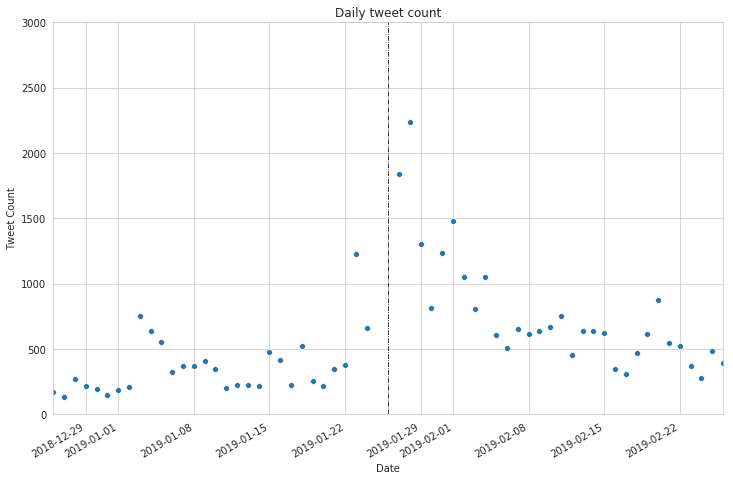

In [274]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-12-26', '%Y-%m-%d'), datetime.datetime.strptime('2019-02-26', '%Y-%m-%d')),
       ylim=(0,3000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2019-01-26', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

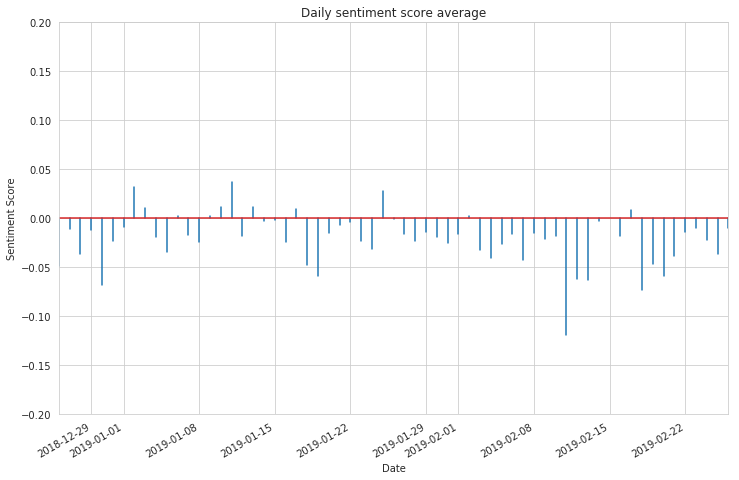

In [326]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-12-26', '%Y-%m-%d'), datetime.datetime.strptime('2019-02-26', '%Y-%m-%d')),
       ylim=(-0.2,0.2),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
fig.autofmt_xdate()
plt.show()

In [327]:
# tweets 
event2 = texts_de['date_only'] == datetime.date(2019,1,26)
event2_tweets = texts_de[event2]

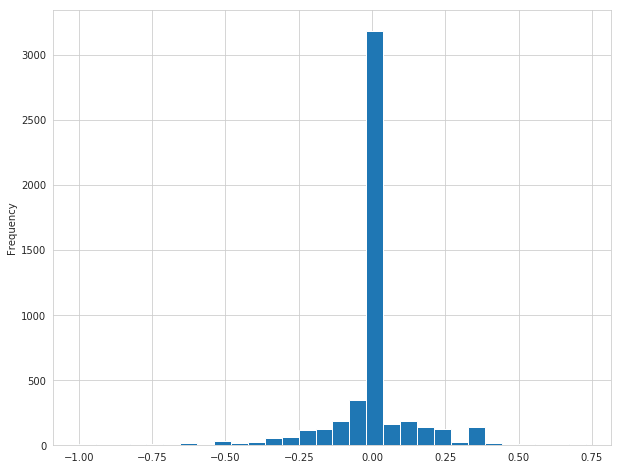

In [328]:
# spread of scores in the day
fig, ax = plt.subplots(figsize=(10,8))

event2_tweets['score'].plot.hist(bins=30)

plt.show()

In [329]:
event2_pos = event2_tweets.sort_values(by='score', ascending=False)
for i in event2_pos.index[:10]:
    print(event2_pos.loc[i]['text'])

Perfekte Idiotie! Die infantile Republik... (und diejenigen, die die Infantilität der anderen für ihre Agenda benutzen...)
#Kohleausstieg #FridaysForFuture #Kohleausstieg https://t.co/XMH2noU7A1
Perfekt wäre es jetzt, wenn die Eltern nach dieser Entscheidung auch noch mit auf die Straße gehen würden #Kohlekommission
#zukunftskommission https://t.co/DPaUtUKLDJ
Perfekt wäre es jetzt, wenn die Eltern nach dieser Entscheidung auch noch mit auf die Straße gehen würden #Kohlekommission
#zukunftskommission https://t.co/DPaUtUtaf9
Ganz dickes Lob an @WDR für diesen Beitrag! #Kohlekommission #Braunkohle - 
@anettselle @wdanslesnuages @klimareport @klimacamp @ImkeByl @MonaNeubaur @bund_net @greenpeace_de @WWF_Deutschland @Ende__Gelaende  @FridayForFuture - #Energiewende muss global angegangen werden! https://t.co/WdIRCz7n3N
Spannend auch, dass der einzige echte #Klimaforscher der #Kohlekommission in der #Bundespressekonferenz gar nicht befragt wird.
@rossreiter @GSiebeke @fuecks Es ist immer seh

In [330]:
event2_neg = event2_tweets.sort_values(by='score')
for i in event2_neg.index[:10]:
    print(event2_neg.loc[i]['text'])

Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr - Foto: Ruhrgebiet, über dts NachrichtenagenturBerlin (dts Nachrichtenagentur) - -
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/zwaLxygYpp
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr - https://t.co/eCJyXydQWb https://t.co/uHCvNBnYwz
UN-Sicherheitsrat: Maas warnt vor Gefahren des Klimawandels https://t.co/pAmLbnC8nG #hambibleibt
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr
 #nachrichten
 https://t.co/HoPrQpxM4A
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/du720M9Oyx https://t.co/Uf0WqlT1q3
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/pIYw1OvNoM https://t.co/BKvJE3t34A
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr - https://t.co/N44Gnixr88
@eysvog3l Gestern wurde in #Kohlekommission der Industriestandort 🇩🇪 von @peteraltmaier @BMWi_Bund beerdigt! 

Wer solche Arbeitervertreter wie @igbce 

### Hambach Forest debate 2018-10-05
> "Court rules clearing operations at Hambach Forest have to be stopped" - CEW

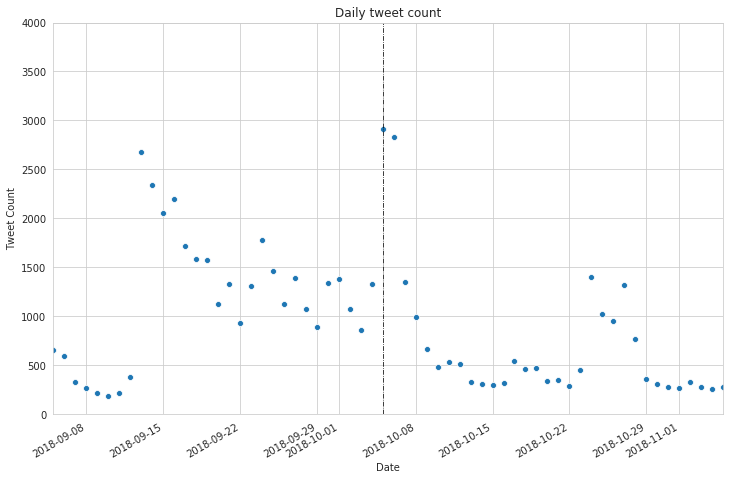

In [275]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-09-05', '%Y-%m-%d'), datetime.datetime.strptime('2018-11-05', '%Y-%m-%d')),
       ylim=(0,4000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2018-10-05', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

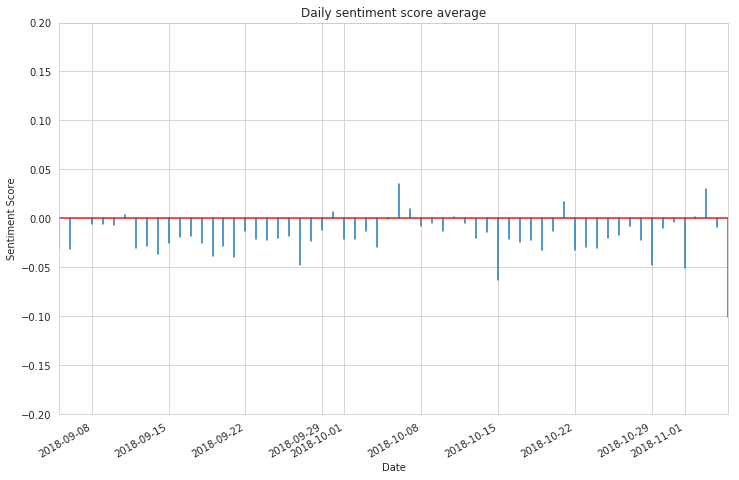

In [331]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-09-05', '%Y-%m-%d'), datetime.datetime.strptime('2018-11-05', '%Y-%m-%d')),
       ylim=(-0.2,0.2),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
fig.autofmt_xdate()
plt.show()

In [332]:
# tweets 
event3 = texts_de['date_only'] == datetime.date(2018,10,5)
event3_tweets = texts_de[event3]

In [333]:
event3_pos = event3_tweets.sort_values(by='score', ascending=False)
for i in event3_pos.index[:10]:
    print(event3_pos.loc[i]['text'])

So wird der Samstag der perfekten Demotag. #hambibleibt https://t.co/YreoXWetoh
So wird der Samstag der perfekten Demotag. #hambibleibt https://t.co/DQMZrwoP0U
So wird der Samstag der perfekten Demotag. #hambibleibt https://t.co/EUGe37bm1B
So wird der Samstag der perfekten Demotag. #hambibleibt https://t.co/MlmsqtSMiW
Tipps für den perfekten Demotag - Tips for the perfect demo-day #HambiBleibt #HambacherForst  - tomorrow 06th of October 2018!!!... #ClimateJustice #EndCoal #Rally #Demonstration #HambachForest #Tipps #Tips &gt;&gt;&gt; https://t.co/c2dfkI7vAp
Ein Lob auf den Rechtsstaat! #hambibleibt #hambacherforst https://t.co/gVFrMyffuI
Wunderbar. #hambibleibt #HambacherWald https://t.co/kOWL5T8RjP
Wunderbare Nachricht: Rote Karte für die @RWE_AG! Gericht hat entschieden, dass #RWE im #HambacherForst vorerst nicht roden darf.  

Wir sagen es immer wieder: Wir wollen, dass #Hambibleibt und #KohleGeht.
https://t.co/a14WCPxuJR https://t.co/WMlATS4BGw
Das haben wir alle mitunterstützt. Un

In [334]:
event3_neg = event3_tweets.sort_values(by='score')
for i in event3_neg.index[:10]:
    print(event3_neg.loc[i]['text'])

Die einzige Gefahr die vom #hambacherwald ausgeht, ist die Polizei selbst &amp; @RWE_AG - #safethetrees &amp; #SaveDemocracy --&gt; #hambibleibt ! https://t.co/jS279iXLsr
@anettselle Die einzige Gefahr die vom #hambacherwald ausgeht, ist die Polizei selbst &amp; @RWE_AG ! #safethetrees = #SaveDemocracy --&gt; #hambibleibt !
Die einzige Gefahr die im #hambacherwald ausgeht, ist die Polizei selbst &amp; @RWE_AG - #safethetrees &amp; #SaveDemocracy --&gt; #hambibleibt ! https://t.co/yNGlhuFv0S
RWE rechnet mit Rodungsstopp im #Hambacherforst bis 2020, die Aktie bricht um 6% ein. Ätsch! #hambibleibt https://t.co/mFCNasNSGv
Ein schlechter Tag für @RWE_AG und ein WUNDERSCHÖN FLUFFIG-FLAUSCHIG-SONNIGER Tag für den #Hambi. #hambibleibt #HambacherForst https://t.co/ksSlAPe11z
Es ist nicht alles schlecht an diesem Freitag. #Hambibleibt * 2 #NobelPeacePrize
Ach, 

surprise: es wird nie zu belegen sein, weil faktisch falsch!
#HambiBleibt https://t.co/GBtbWS6pR6
Wir wissen nicht, was da los ist, abe